In [1]:
import os
import sys
import math
import logging
from pathlib import Path
from datetime import datetime

import numpy as np
import scipy as sp
from scipy import stats
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

In [2]:
np.random.seed(42)

# Honey, I shrunk the target variable!

Read first the accompanying article on my [blog](https://florianwilhelm.info/2020/05/honey_i_shrunk_the_target_variable/) to understand what's going on here.

Download the data from [Kaggle used-cars database](https://www.kaggle.com/orgesleka/used-cars-database), unzip it and put it under `../data/raw`

In [3]:
!ls ../data/raw/  # this should show "autos.csv"

autos.csv


In [4]:
data_dir = Path('../data/raw')
autos_csv = data_dir / Path('autos.csv')

In [5]:
df = pd.read_csv(autos_csv, encoding='cp850')
print(list(df.columns))

['dateCrawled', 'name', 'seller', 'offerType', 'price', 'abtest', 'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS', 'model', 'kilometer', 'monthOfRegistration', 'fuelType', 'brand', 'notRepairedDamage', 'dateCreated', 'nrOfPictures', 'postalCode', 'lastSeen']


Let's concentrate only on working cars in a reasonable price range which are sold

In [6]:
df = df.query('price <= 50_000 and notRepairedDamage == "nein" and price > 200 and offerType == "Angebot"')

In [7]:
df.describe()

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
count,256640.000000,256640.000000,256640.000000,256640.000000,256640.000000,256640.0,256640.000000
mean,6704.024314,2004.127229,124.656901,123263.462438,6.166771,0.0,51630.454462
std,7174.017565,27.962960,162.600851,40189.158129,3.491749,0.0,25870.586593
min,205.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1800.000000,2000.000000,75.000000,100000.000000,3.000000,0.0,31139.000000
50%,4100.000000,2004.000000,116.000000,150000.000000,6.000000,0.0,50823.000000
75%,8950.000000,2009.000000,150.000000,150000.000000,9.000000,0.0,72622.000000
max,50000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [8]:
# create 1000 Euro bins for price-ranges
bins = 1000*np.arange(50)

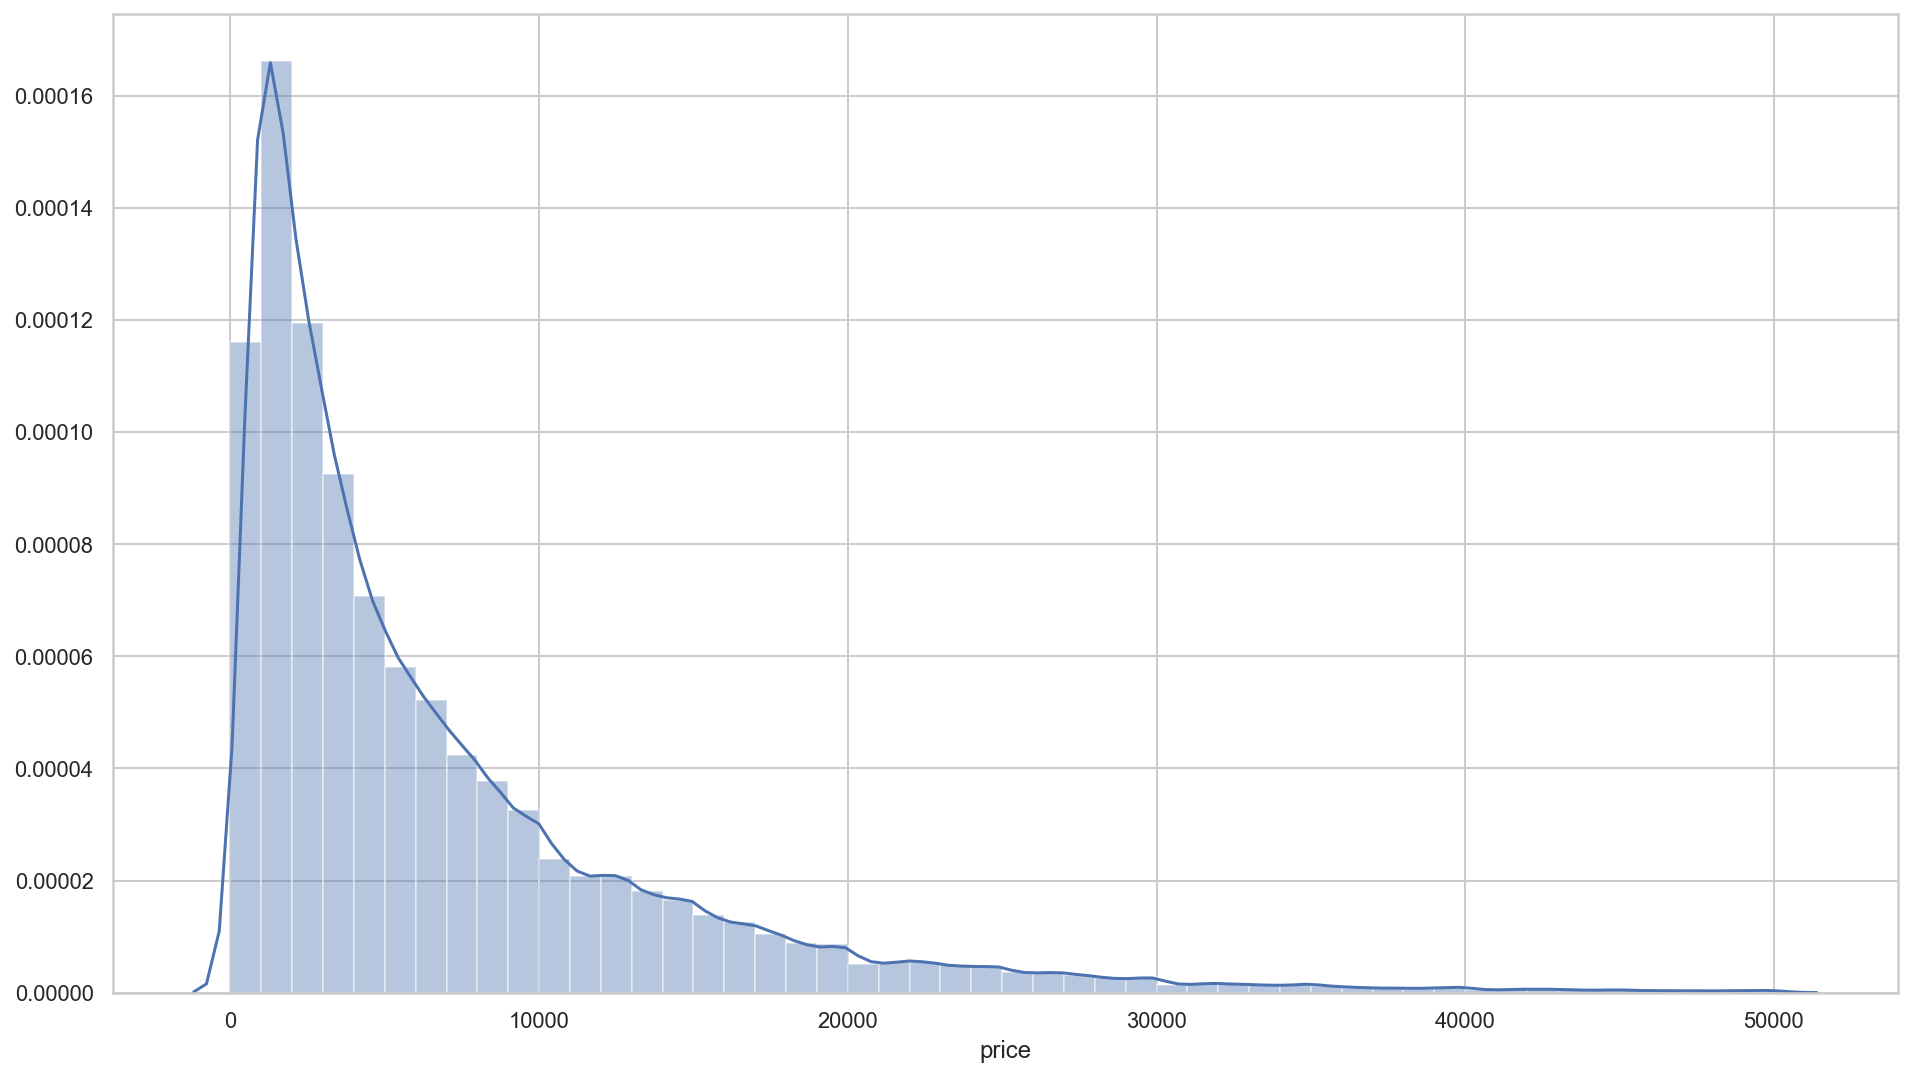

In [9]:
sns.distplot(df.price, bins=bins);

The price looks definitely not normal distributed rather log-normal distributed. Let's check that visually.

We fit a log-normal distribution, sample from it and see it it looks similar

In [10]:
shape, loc, scale = stats.lognorm.fit(df.price, floc=0.)
dist = stats.lognorm(shape, loc, scale)
rvs = dist.rvs(100_000)

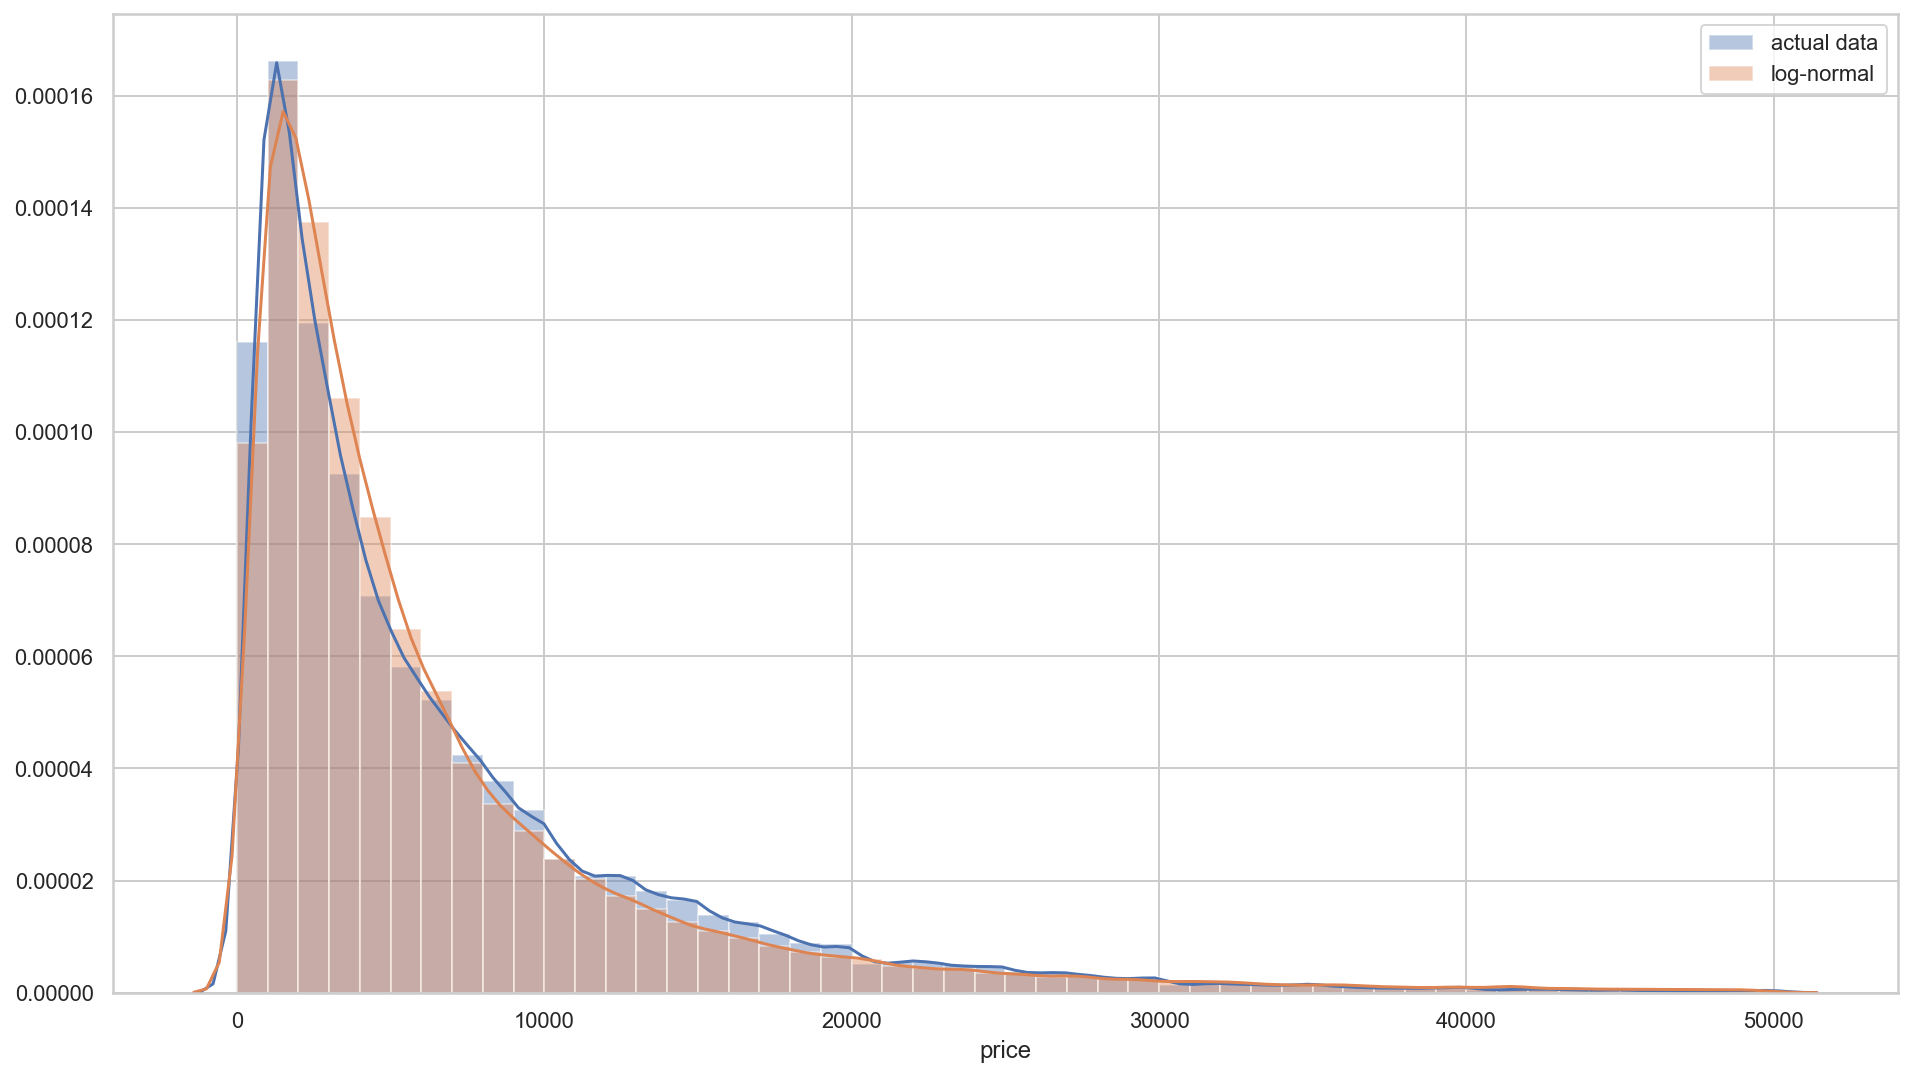

In [11]:
sns.distplot(df.price, bins=bins, label='actual data')
sns.distplot(rvs[rvs<50_000], bins=bins, label='log-normal')
plt.legend();

## Distribution of the target variable

In [12]:
# Use some simple linear model to generate the target variable
N = 10000
x = np.random.randint(2, size=N)
y = x + 0.3*np.random.randn(N)

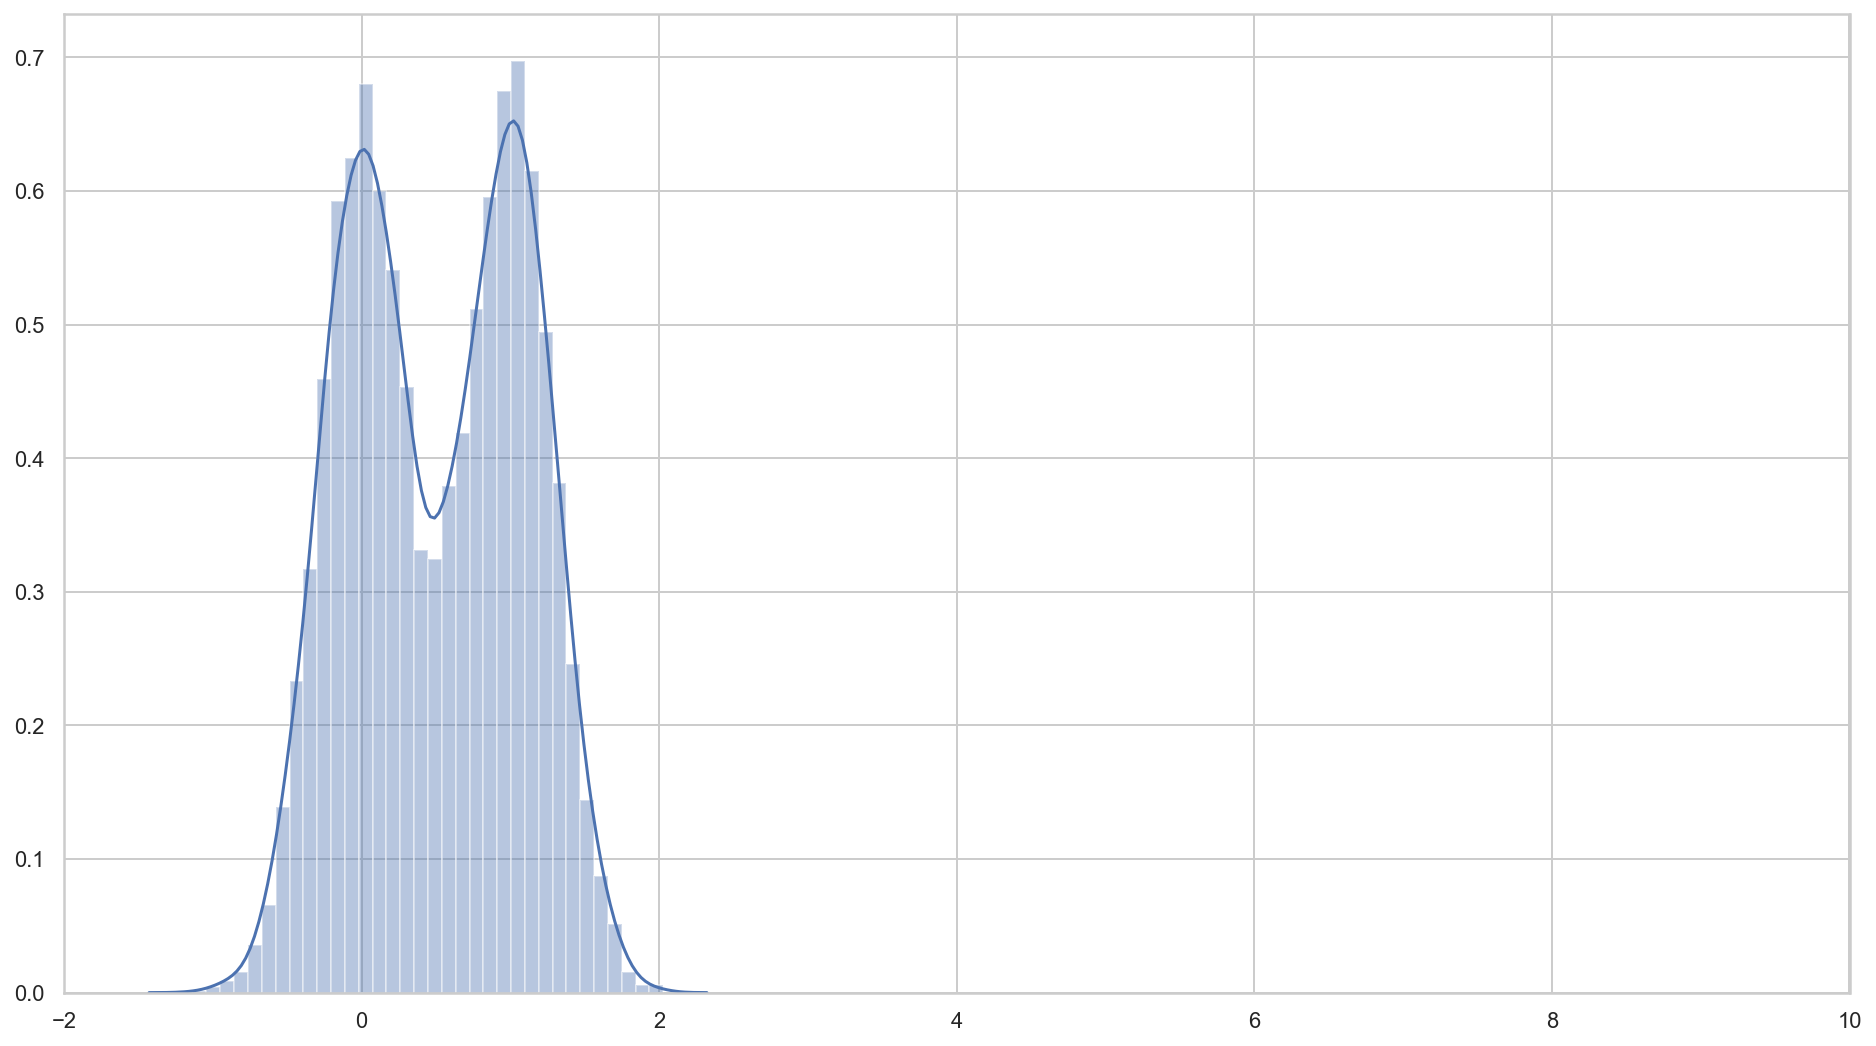

In [13]:
# Obviously, the outcome of a linear model doesn't have to be normally distributed.
sns.distplot(y)
plt.xlim(-2, 10);

## Analysis of the residual distribution

In [14]:
# All kinds of error measures we need

def rmse(y_pred, y_true):
    """Root Mean Squared Error"""
    # not taking the root, i.e. MSE, would not change the actual minimum point
    return np.sqrt(np.mean((y_true - y_pred)**2))


def mae(y_pred, y_true):
    """Mean Absolute Error"""
    return np.mean(np.abs(y_true - y_pred))


def mape(y_pred, y_true):
    """Mean Average Percentage Error"""
    return np.mean(np.abs((y_true - y_pred)/y_true))


def rmspe(y_pred, y_true):
    """Root Mean Squared Percentage Error"""
    return np.sqrt(np.mean(((y_true - y_pred)/y_true)**2))

In [15]:
y = df.price.to_numpy()

In [16]:
res = sp.optimize.minimize(rmse, 1., args=(y,))
res

      fun: 7174.003600843465
 hess_inv: array([[7052.74958795]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 5
     njev: 12
   status: 0
  success: True
        x: array([6703.59325181])

In [17]:
np.mean(y)

6704.024314214464

In [18]:
res = sp.optimize.minimize(mae, 1., options=dict(gtol=2e-4), args=(y,))
res

      fun: 4743.492333474732
 hess_inv: array([[7862.69627309]])
      jac: array([-0.00018311])
  message: 'Optimization terminated successfully.'
     nfev: 120
      nit: 8
     njev: 40
   status: 0
  success: True
        x: array([4099.9946168])

In [19]:
np.median(y)

4100.0

## Shrinking the target variable

In [20]:
y_log = np.log(df.price.to_numpy())

In [21]:
res_y = sp.optimize.minimize(rmse, 8., args=(y_log,), tol=1e-16)
res_y

      fun: 1.066675943730279
 hess_inv: array([[1.11749076]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 5
     njev: 10
   status: 0
  success: True
        x: array([8.29160403])

In [22]:
np.exp(res_y.x)

array([3990.22949901])

This value rather resembles the median of the original distribution.

Let's see how it looks for our fitted log-normal distribution.

In [23]:
np.median(rvs)

4001.522966016775

In [24]:
rvs_log = np.log(rvs)
res_rvs = sp.optimize.minimize(rmse, 1., args=(rvs_log,), tol=1e-10)
res_rvs

      fun: 1.0676369700030393
 hess_inv: array([[1.06764743]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 5
     njev: 10
   status: 0
  success: True
        x: array([8.29263537])

In [25]:
np.exp(res_rvs.x)

array([3994.34689899])

So it's even closer to the median of the original distribution!

Let's calculate the mean of the original distrubtion using the transformed one.

In [26]:
mu = res_y.x[0]
sigma2 = rmse(mu, y_log)**2
np.exp(mu + sigma2/2)

7048.025680339902

which is now much closer to 

In [27]:
np.mean(y)

6704.024314214464

and for the log-normal distribution

In [28]:
mu = res_rvs.x[0]
sigma2 = rmse(mu, rvs_log)**2
np.exp(mu + sigma2/2)

7062.537711299532

we get the expected value up to some error due to the sampling

In [29]:
np.mean(rvs)

7054.824096461791

Let's do the same for MAPE. First for y:

In [30]:
sp.optimize.minimize(mape, 1000., args=(y,), tol=1e-10)

      fun: 0.6969046987305233
 hess_inv: array([[0.00081973]])
      jac: array([8.86619091e-07])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 414
      nit: 4
     njev: 134
   status: 2
  success: False
        x: array([1200.])

In [31]:
mu = res_y.x[0]
sigma2 = rmse(mu, rvs_log)**2
np.exp(mu - sigma2)

1276.3430342548838

and then for the log-normal distribution:

In [32]:
sp.optimize.minimize(mape, 1., args=(rvs,), tol=1e-10)

      fun: 0.7142317935544468
 hess_inv: array([[3761612.48424339]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 75
      nit: 6
     njev: 25
   status: 0
  success: True
        x: array([1275.3386318])

In [33]:
mu = res_rvs.x[0]
sigma2 = rmse(mu, rvs_log)**2
np.exp(mu - sigma2)

1277.6614139408068

So we see that a correction of -sigma2 is needed to transform the minimum point of the log-transformed target back to get the minimum point of MAPE on the untransformed target.

## Transforming the target for fun and profit

Shuffle the rows for KFold later

In [34]:
# Decrease to trade accuracy for speed
CV_SPLITS = 10
FRACTION = 1.0

In [35]:
# make this 1.0 later
df = df.sample(frac=FRACTION).reset_index(drop=True)

Merge year and month of registration and convert to timestamp

In [36]:
df['monthOfRegistration'] = df['monthOfRegistration'].replace(0, 7)
df['ageInYears'] = df[["yearOfRegistration", "monthOfRegistration"]].apply(
    lambda ds: (datetime(ds["yearOfRegistration"], ds["monthOfRegistration"], 1) - datetime.now()).days / 365, axis=1)
df['mileageOverAge'] = df['kilometer'] / df['ageInYears']

In [37]:
FEATURES = ["vehicleType", 
            "ageInYears",
            "mileageOverAge",
            "gearbox", 
            "powerPS",
            "model",
            "kilometer", 
            "fuelType",
            "brand",
            "price"]
df = df[FEATURES].copy()

In [38]:
for col, dtype in zip(df.columns, df.dtypes):
    if dtype is np.dtype('O'):
        df[col] = df[col].astype('category').cat.codes

In [39]:
y = df['price'].to_numpy()
X = df.drop(columns='price').to_numpy()

In [40]:
METRICS = ['rmse', 'mae', 'mape', 'rmspe']

In [41]:
def get_corr(y_true, y_pred_log, error_func):
    """Determine correction delta for exp transformation"""
    res = sp.optimize.minimize(lambda delta: error_func(np.exp(delta + y_pred_log), y_true), 0.)
    return res.x

In [42]:
reg = RandomForestRegressor()
results = []
for i, (train_idx, test_idx) in enumerate(KFold(n_splits=CV_SPLITS).split(X)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)
    
    # raw untransformed target
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    res = dict(target='raw',
               split=i,
               rmse=rmse(y_pred, y_test),
               mae=mae(y_pred, y_test),
               mape=mape(y_pred, y_test),
               rmspe=rmspe(y_pred, y_test))
    results.append(res)
    
    # log-transformed target
    y_train_log = np.log(y_train)
    reg.fit(X_train, y_train_log)
    y_log_pred = reg.predict(X_test)
    y_pred = np.exp(y_log_pred)
    res = dict(target='log & no corr',
               split=i,
               rmse=rmse(y_pred, y_test),
               mae=mae(y_pred, y_test),
               mape=mape(y_pred, y_test),
               rmspe=rmspe(y_pred, y_test))
    results.append(res)
    
    # log-transformed target and sigma2 correction
    y_val_log_pred = reg.predict(X_val)
    sigma2 = rmse(y_val_log_pred, np.log(y_val))**2
    res = dict(target='log & sigma2 corr',
               split=i,
               rmse=rmse(np.exp(y_log_pred + 0.5*sigma2), y_test),
               mae=mae(np.exp(y_log_pred), y_test),
               mape=mape(np.exp(y_log_pred - sigma2), y_test),
               rmspe=rmspe(np.exp(y_log_pred - 1.5*sigma2), y_test))
    results.append(res)
    
    # log-transformed target and fitted correction
    res = dict(target='log & fitted corr',
               split=i,
               rmse=rmse(np.exp(y_log_pred + get_corr(y_val, y_val_log_pred, rmse)), y_test),
               mae=mae(np.exp(y_log_pred + get_corr(y_val, y_val_log_pred, mae)), y_test),
               mape=mape(np.exp(y_log_pred + get_corr(y_val, y_val_log_pred, mape)), y_test),
               rmspe=rmspe(np.exp(y_log_pred + get_corr(y_val, y_val_log_pred, rmspe)), y_test))
    results.append(res)

    
df = pd.DataFrame(results, columns=['split', 'target', *METRICS])

In [43]:
df

,split,target,rmse,mae,mape,rmspe
0,0,raw,2376.687477,1277.892725,0.351623,1.402544
1,0,log & no corr,2456.981889,1262.119946,0.303494,1.212133
2,0,log & sigma2 corr,2475.667977,1262.119946,0.302080,0.976834
3,0,log & fitted corr,2440.388803,1260.425009,0.294991,0.740349
4,1,raw,2330.468963,1255.436421,0.346038,1.270573
5,1,log & no corr,2409.880320,1246.056422,0.301652,1.108160
6,1,log & sigma2 corr,2437.463760,1246.056422,0.302059,0.890653
7,1,log & fitted corr,2395.109058,1244.228867,0.293522,0.725838
8,2,raw,2384.851274,1269.237492,0.342760,1.400268
9,2,log & no corr,2450.920761,1258.126201,0.299086,1.216544


In [44]:
rel_df = (df.groupby('split')
            .apply(lambda X: (X[METRICS].iloc[1:] / X[METRICS].iloc[0] - 1.)
                             .set_index(X['target'].iloc[1:]))
         )

In [45]:
rel_df.applymap(lambda x: f"{x:+.2%}")

rmse     mae     mape    rmspe
split target                                             
0     log & no corr      +3.38%  -1.23%  -13.69%  -13.58%
      log & sigma2 corr  +4.16%  -1.23%  -14.09%  -30.35%
      log & fitted corr  +2.68%  -1.37%  -16.11%  -47.21%
1     log & no corr      +3.41%  -0.75%  -12.83%  -12.78%
      log & sigma2 corr  +4.59%  -0.75%  -12.71%  -29.90%
      log & fitted corr  +2.77%  -0.89%  -15.18%  -42.87%
2     log & no corr      +2.77%  -0.88%  -12.74%  -13.12%
      log & sigma2 corr  +3.28%  -0.88%  -12.43%  -29.73%
      log & fitted corr  +1.98%  -1.03%  -14.84%  -45.84%
3     log & no corr      +3.50%  -1.57%  -13.89%  -18.13%
      log & sigma2 corr  +4.19%  -1.57%  -14.40%  -34.27%
      log & fitted corr  +2.74%  -1.75%  -16.40%  -53.96%
4     log & no corr      +0.72%  -1.74%  -12.99%  -11.09%
      log & sigma2 corr  +2.07%  -1.74%  -12.93%  -28.56%
      log & fitted corr  +0.18%  -1.88%  -15.31%  -48.45%
5     log & no corr      +3.33%  -0.56%  -11.81%   -7.71%
      log & sigma2 corr  +4.65%  -0.56%  -13.00%  -25.99%
      log & fitted corr  +2.87%  -0.60%  -14.64%  -52.14%
6     log & no corr      +2.90%  -1.09%  -13.89%  -26.95%
      log & sigma2 corr  +3.96%  -1.09%  -13.86%  -41.26%
      log & fitted corr  +2.22%  -1.23%  -16.28%  -52.09%
7     log & no corr      +1.92%  -1.41%  -13.40%  -15.14%
      log & sigma2 corr  +3.28%  -1.41%  -13.88%  -31.76%
      log & fitted corr  +1.44%  -1.46%  -15.96%  -48.84%
8     log & no corr      +3.18%  -0.93%  -12.80%  -11.09%
      log & sigma2 corr  +4.49%  -0.93%  -12.31%  -28.96%
      log & fitted corr  +2.55%  -1.08%  -15.00%  -49.02%
9     log & no corr      +3.21%  -0.68%  -12.75%   -9.07%
      log & sigma2 corr  +3.40%  -0.68%  -12.59%  -26.41%
      log & fitted corr  +2.30%  -0.86%  -14.93%  -44.94%

In [46]:
total_rel_df = rel_df.reset_index().groupby('target', sort=False)[METRICS].agg(['mean', 'std'])
for col_idx in total_rel_df.columns:
    if col_idx[1] == 'mean':
        fmt = lambda x: f"{x:+.2%}"
    else:
        fmt = lambda x: f"±{x:.2%}p"
    total_rel_df[col_idx] = total_rel_df[col_idx].apply(fmt)

In [47]:
total_rel_df

rmse              mae              mape           \
                     mean      std    mean      std     mean      std   
target                                                                  
log & no corr      +2.83%  ±0.87%p  -1.08%  ±0.39%p  -13.08%  ±0.65%p   
log & sigma2 corr  +3.81%  ±0.80%p  -1.08%  ±0.39%p  -13.22%  ±0.76%p   
log & fitted corr  +2.17%  ±0.83%p  -1.22%  ±0.40%p  -15.46%  ±0.65%p   

                     rmspe           
                      mean      std  
target                               
log & no corr      -13.87%  ±5.47%p  
log & sigma2 corr  -30.72%  ±4.41%p  
log & fitted corr  -48.54%  ±3.49%p